In [1]:
#!pip install pillow torch torchvision fastai scikit-image ipywidgets
!jupyter nbextension enable --py widgetsnbextension
from PIL import Image
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import skimage.transform
import skimage.morphology
from scipy.signal import medfilt
from skimage.measure import regionprops
from ipywidgets import FloatProgress

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
#!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import random
import os
import json

import skimage.io
import skimage.transform

from torch.utils.data import Dataset
import torchvision.transforms.functional as TF



In [3]:
#!pip install opencv-python albumentations
import albumentations as albu
import cv2

In [59]:
DEEP_FASHION2_CUSTOM_CLASS_MAP = {
    1: "trousers",
    2: "skirt",
    3: "top",
    4: "dress",
    5: "outwear",
    6: "shorts"
}

deepfashion_keys = list(DEEP_FASHION2_CUSTOM_CLASS_MAP.values())

class SegmentationDataset(Dataset):

    def __init__(self,
                 path: str,
                 image_resize: int,
                 subset: str = 'train',
                 data_augmentation = None,
                 preprocessing = None):
        """
        Args:
            path: Path to the root directory of the dataset. Directory is
                expected to contain:
                - data.json: dataset descriptor, containing at least
                    `image_path' (i.e. path to the raw image), 'mask_path'
                    (i.e. path to mask) and 'set' (i.e. train/validation/test).
                - any other required files or directories (i.e. image dirs).
            image_resize: Size images will be resized into.
            subset: Data to retrieve (i.e. train/validation/test).
            data_augmentation: Data augmentation parameters.
        """
        
        DEEP_FASHION2_CUSTOM_CLASS_MAP = {
            1: "trousers",
            2: "skirt",
            3: "top",
            4: "dress",
            5: "outwear",
            6: "shorts"
        }
        self.class_values = list(DEEP_FASHION2_CUSTOM_CLASS_MAP.keys())
        
        self._image_resize = image_resize

        valid_subsets = ['train', 'validation', 'test']
        if subset not in valid_subsets:
            raise ValueError(
                f'Subset must be one of {valid_subsets}. Is "{subset}"'
            )

        self._data_augmentation = data_augmentation

        with open(os.path.join(path, 'data.json'), 'r') as file:
            data = json.load(file)

        images = [os.path.join(path, row['image_path'].replace("\\", "/"))
                  for row in data if row['set'] == subset]
        masks = [os.path.join(path, row['mask_path'].replace("\\", "/"))
                 for row in data if row['set'] == subset]

        print(len(images), len(masks))

        # Read only existing image + mask pairs
        self._image_mask_pairs = np.array([
            (img, mask)
            for (img, mask) in zip(images, masks)
            if os.path.isfile(img) and os.path.isfile(mask)
        ])
        print(f'Read {len(images)} images, built ' +
              f'{len(self._image_mask_pairs)} image pairs')

        self.preprocessing = preprocessing
        
    def _transform(self, image, mask):
        image = TF.to_pil_image(_resize_image(image, self._image_resize))
        mask = TF.to_pil_image(_resize_mask(mask, self._image_resize))

        if self._data_augmentation is not None:
            image, mask = self._data_augmentation.augment(image, mask)

        # Image normalization
        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=(0,), std=(1,))(image)
        return image.float(), np.array(mask)

    def __len__(self):
        return len(self._image_mask_pairs)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path, mask_path = self._image_mask_pairs[idx]
        ii = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        mm = cv2.imread(mask_path,0)
        print(ii.shape, mm.shape)
        if self.preprocessing:
            print(self.preprocessing)
            #sample = self.preprocessing(image=ii, mask=mm)
            #ii, mm = sample['image'], sample['mask']
            #print(ii.shape, mm.shape)

        
        image = skimage.io.imread(image_path)
        mask = skimage.io.imread(mask_path)
        return self._transform(image, mask)
        

def _resize_image(img: np.ndarray, new_size: int) -> np.ndarray:
    return skimage.transform.resize(img,
                                    (new_size, new_size),
                                    preserve_range=True,
                                    order=0).astype('uint8')


def _resize_mask(mask: np.ndarray, new_size: int) -> np.ndarray:
    return skimage.transform.resize(mask,
                                    (new_size, new_size),
                                    order=0,  # mode=nearest
                                    anti_aliasing=False,
                                    preserve_range=True).astype('uint8')

In [53]:
data = SegmentationDataset('deep_fashion_segmentation_dataset',
                               image_resize=240, preprocessing=preprocessing_fn)

30957 30957
Read 30957 images, built 30957 image pairs


In [23]:
def get_training_augmentation():
    train_transform = [
        
        albu.Resize(320,320),
        
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=0.5),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(480,480),
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

In [11]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

class SegmentationDataset2(Dataset):
    def __init__(self,
                 path: str,
                 image_resize = 240,
                 subset: str = 'train',
                 augmentation = None,
                 preprocessing = None):
        """
        Args:
            path: Path to the root directory of the dataset. Directory is
                expected to contain:
                - data.json: dataset descriptor, containing at least
                    `image_path' (i.e. path to the raw image), 'mask_path'
                    (i.e. path to mask) and 'set' (i.e. train/validation/test).
                - any other required files or directories (i.e. image dirs).
            image_resize: Size images will be resized into.
            subset: Data to retrieve (i.e. train/validation/test).
            data_augmentation: Data augmentation parameters.
        """

        DEEP_FASHION2_CUSTOM_CLASS_MAP = {
            1: "trousers",
            2: "skirt",
            3: "top",
            4: "dress",
            5: "outwear",
            6: "shorts"
        }
        self.class_values = list(DEEP_FASHION2_CUSTOM_CLASS_MAP.keys())
        self._image_resize = image_resize

        valid_subsets = ['train', 'validation', 'test']
        if subset not in valid_subsets:
            raise ValueError(
                f'Subset must be one of {valid_subsets}. Is "{subset}"'
            )


        with open(os.path.join(path, 'data.json'), 'r') as file:
            data = json.load(file)

        images = [os.path.join(path, row['image_path'].replace("\\", "/"))
                  for row in data if row['set'] == subset]
        masks = [os.path.join(path, row['mask_path'].replace("\\", "/"))
                 for row in data if row['set'] == subset]
        
        print(len(images), len(masks))

        # Read only existing image + mask pairs
        self._image_mask_pairs = np.array([
            (img, mask)
            for (img, mask) in zip(images, masks)
            if os.path.isfile(img) and os.path.isfile(mask)
        ])
        print(f'Read {len(images)} images, built ' +
              f'{len(self._image_mask_pairs)} image pairs')

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):
        
        # read data
        image_path, mask_path = self._image_mask_pairs[i]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, 0)
        
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # extract certain classes from mask (e.g. cars)
        #masks = [(mask == v) for v in self.class_values]
        #mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self._image_mask_pairs)
        

In [6]:
d2 = SegmentationDataset2('deep_fashion_segmentation_dataset',
                               image_resize=240, augmentation=get_training_augmentation())#, preprocessing=get_preprocessing(preprocessing_fn))

30957 30957
Read 30957 images, built 30957 image pairs


In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


In [8]:
im, m = d2[1]
im.shape, m.shape

((320, 320, 3), (320, 320, 6))

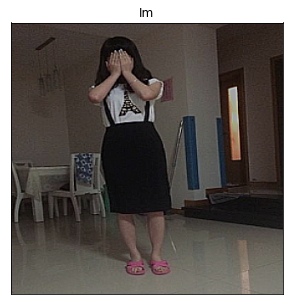

In [20]:
visualize(im = im)

In [5]:
def display_dataset(data):
    n_rows = 5
    idxs = [random.randint(0, len(data)) for _ in range(n_rows)]
    fig, axs = plt.subplots(n_rows, 2, figsize=(7.0, n_rows*3.0))
    for i, idx in enumerate(idxs):
        image, mask = data[idx]
        axs[i][0].imshow(np.transpose(image, (1, 2, 0)))
        axs[i][0].set_title('Sample image #{}'.format(i))
        axs[i][1].imshow(mask)
        labels = np.unique(mask)
        axs[i][1].set_title('Sample mask #{}. Labels: {}'.format(i, labels))

    plt.tight_layout()
    plt.show()

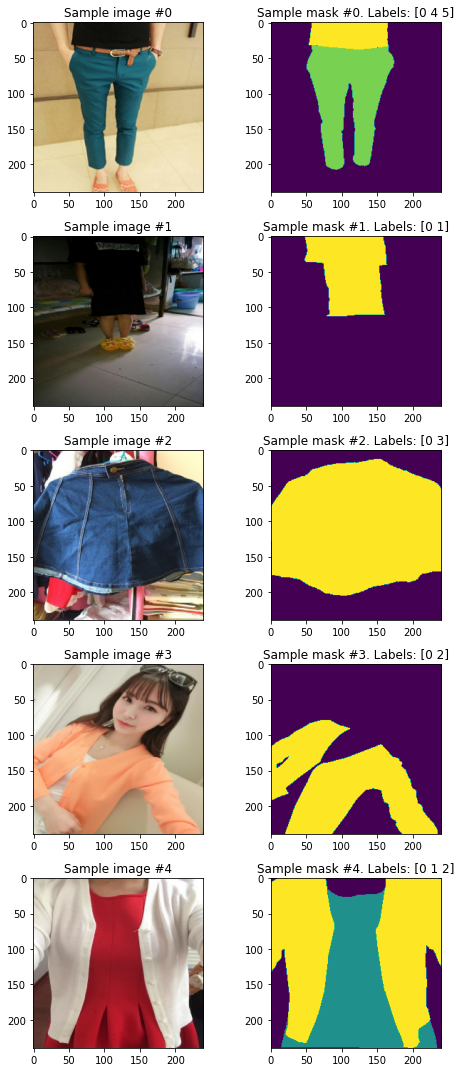

In [6]:
display_dataset(data)

In [9]:
#ENCODER = 'timm-efficientnet-b6'
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = [1,2,3,4,5,6]
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'

print(DEVICE)

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

cuda:0


In [24]:
#d2 = SegmentationDataset2('deep_fashion_segmentation_dataset',
#                               image_resize=240, augmentation=get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

train_dir = 'deep_fashion_segmentation_dataset'

train_dataset = SegmentationDataset2(
    train_dir,
    subset = 'train',
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = SegmentationDataset2(
    train_dir,
    subset = 'validation',
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=1)

30957 30957
Read 30957 images, built 30957 image pairs
392 392
Read 392 images, built 392 image pairs


In [14]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4),
])

In [1]:
#model = model.half() # 16 bit precision
# Do later, since smp gives error with half precision currently

In [19]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [29]:
max_score = 0

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')


Epoch: 0
valid: 100%|██████████| 392/392 [00:37<00:00, 10.53it/s, dice_loss - 0.7272, iou_score - 0.1799]
Model saved!

Epoch: 1
valid: 100%|██████████| 392/392 [00:36<00:00, 10.64it/s, dice_loss - 0.7085, iou_score - 0.1938]
Model saved!

Epoch: 2
train:  47%|████▋     | 917/1935 [27:51<30:55,  1.82s/it, dice_loss - 0.6791, iou_score - 0.1944] 


KeyboardInterrupt: 

In [26]:
d2[0][0].shape, d2[0][1].shape

((3, 320, 320), (6, 320, 320))